In [11]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import os
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from IPython.display import Image
from keras import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras import datasets, layers, models, losses
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import zipfile
!unzip /content/CIFAKE.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/REAL/4500 (10).jpg  
  inflating: train/REAL/4500 (2).jpg  
  inflating: train/REAL/4500 (3).jpg  
  inflating: train/REAL/4500 (4).jpg  
  inflating: train/REAL/4500 (5).jpg  
  inflating: train/REAL/4500 (6).jpg  
  inflating: train/REAL/4500 (7).jpg  
  inflating: train/REAL/4500 (8).jpg  
  inflating: train/REAL/4500 (9).jpg  
  inflating: train/REAL/4500.jpg     
  inflating: train/REAL/4501 (10).jpg  
  inflating: train/REAL/4501 (2).jpg  
  inflating: train/REAL/4501 (3).jpg  
  inflating: train/REAL/4501 (4).jpg  
  inflating: train/REAL/4501 (5).jpg  
  inflating: train/REAL/4501 (6).jpg  
  inflating: train/REAL/4501 (7).jpg  
  inflating: train/REAL/4501 (8).jpg  
  inflating: train/REAL/4501 (9).jpg  
  inflating: train/REAL/4501.jpg     
  inflating: train/REAL/4502 (10).jpg  
  inflating: train/REAL/4502 (2).jpg  
  inflating: train/REAL/4502 (3).jpg  
  inflating: train/REAL/4502 (4).jpg  
  inflating:

In [5]:
dataset_dir = "train"
img_height = 32
img_width = 32
batch_size = 500

# Load training and validation data
train, val = keras.utils.image_dataset_from_directory(
  os.path.join(dataset_dir, ""),
  validation_split=0.2,
  subset="both",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Using 20000 files for validation.


In [6]:
test = keras.utils.image_dataset_from_directory(
  os.path.join("test"),
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 20000 files belonging to 2 classes.


In [7]:
classes = train.class_names
classes

['FAKE', 'REAL']

In [8]:
input = layers.Input(shape=(32,32,3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=(32,32,3))(input)
# 7x7 convolution with stride 2 and 64 filters
x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_tensor)
# 3x3 max pooling with stride 2
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
# 1x1 convolution with 64 filters
x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
# 3x3 convolution with 192 filters
x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
# 3x3 max pooling with stride 2
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
#inception 1
branch1 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(96, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(16, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(32, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
#inception 2
branch1 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(96, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
#inception 3
branch1 = layers.Conv2D(192, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(96, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(208, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(16, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(48, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
#auxiliary 1
auxx = layers.AveragePooling2D((5, 5), strides=(3, 3))(x)
auxx = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(auxx)
auxx = layers.Flatten()(auxx)
auxx = layers.Dense(1024, activation='relu')(auxx)
auxx = layers.Dropout(0.7)(auxx)
auxx = layers.Dense(1, activation='sigmoid', name="aux1")(auxx)
#inception 4
branch1 = layers.Conv2D(160, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(112, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(224, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(24, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
#inception 5
branch1 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(24, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
#inception 6
branch1 = layers.Conv2D(112, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(144, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(288, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
#auxiliary 2
auxx2 = layers.AveragePooling2D((5, 5), strides=(3, 3))(x)
auxx2 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(auxx2)
auxx2 = layers.Flatten()(auxx2)
auxx2 = layers.Dense(1024, activation='relu')(auxx2)
auxx2 = layers.Dropout(0.7)(auxx2)
auxx2 = layers.Dense(1, activation='sigmoid', name="aux2")(auxx2)
#inception 7
branch1 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(160, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(320, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(128, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
#inception 8
branch1 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(160, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(320, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(128, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
#inception 9
branch1 = layers.Conv2D(384, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(192, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(384, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(48, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(128, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)

x = layers.AveragePooling2D((7, 7), strides=(1, 1))(x)
x = layers.Dropout(0.4)(x)
x = layers.Flatten()(x)

output = layers.Dense(1, activation='sigmoid', name='output')(x)

model = keras.Model(input, [output, auxx, auxx2], name='inceptionnet')

In [15]:
model.compile(optimizer='adam',
              loss=[losses.binary_crossentropy, losses.binary_crossentropy, losses.binary_crossentropy],
              loss_weights=[1, 0.3, 0.3],
              metrics=["accuracy", metrics.Precision(name="precision"), metrics.Recall(name="recall")])

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_output_accuracy', mode='max', patience=5,  restore_best_weights=True)
model.summary()

Model: "inceptionnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 resizing (Resizing)         (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['resizing[0][0]']            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)           0         ['conv2d[0][0]']              
 D)                                                                                    

In [16]:
epochs = 40

history = model.fit(
  train,
  validation_data=val,
  epochs=epochs,
  verbose=3, callbacks=[es])



Epoch 1/40


KeyboardInterrupt: 

In [12]:
history = pd.DataFrame(history.history)
display(history)

,loss,output_loss,aux1_loss,aux2_loss,output_accuracy,output_precision,output_recall,aux1_accuracy,aux1_precision,aux1_recall,...,val_aux2_loss,val_output_accuracy,val_output_precision,val_output_recall,val_aux1_accuracy,val_aux1_precision,val_aux1_recall,val_aux2_accuracy,val_aux2_precision,val_aux2_recall
0,1.148738,0.720857,0.727642,0.698627,0.555100,0.553721,0.566212,0.587038,0.586212,0.590772,...,0.649375,0.62355,0.611640,0.679980,0.52060,0.828968,0.053719,0.63665,0.683298,0.511433
1,1.054483,0.662276,0.655413,0.651943,0.608938,0.596891,0.670201,0.614362,0.608717,0.639515,...,0.598505,0.68710,0.788600,0.512531,0.67645,0.839594,0.437444,0.67540,0.800751,0.468298
2,0.696003,0.435793,0.429589,0.437776,0.799400,0.792235,0.811454,0.801225,0.792988,0.815081,...,0.345097,0.84285,0.808549,0.899051,0.85375,0.832676,0.885971,0.84765,0.843725,0.853919
3,0.484284,0.302940,0.300818,0.303660,0.870025,0.867531,0.873302,0.871363,0.866448,0.877954,...,0.245185,0.88940,0.855555,0.937394,0.89810,0.890150,0.908637,0.89960,0.886924,0.916326
4,0.379367,0.235795,0.242556,0.236018,0.904262,0.901426,0.907715,0.900587,0.896534,0.905615,...,0.227726,0.90975,0.940167,0.875487,0.90915,0.905761,0.913630,0.90800,0.942897,0.868897
5,0.331742,0.205347,0.216203,0.205114,0.917775,0.915025,0.921020,0.913737,0.909212,0.919195,...,0.174367,0.93070,0.915615,0.949076,0.92340,0.909609,0.940489,0.93175,0.921130,0.944583
6,0.285688,0.175748,0.189908,0.176561,0.930287,0.927492,0.933500,0.923200,0.920145,0.926773,...,0.174376,0.92980,0.906678,0.958462,0.92150,0.888133,0.964753,0.93075,0.910171,0.956066
7,0.261770,0.161572,0.172528,0.161464,0.936550,0.934700,0.938627,0.931962,0.928646,0.935776,...,0.151670,0.94120,0.949913,0.931702,0.93135,0.961744,0.898652,0.94215,0.951294,0.932202
8,0.239299,0.146902,0.160914,0.147076,0.943062,0.941484,0.944804,0.937887,0.935133,0.941003,...,0.151260,0.94310,0.958475,0.926510,0.93890,0.961091,0.915027,0.94180,0.964912,0.917124
9,0.224786,0.137736,0.152220,0.137945,0.946675,0.946856,0.946430,0.941113,0.940067,0.942253,...,0.171163,0.92935,0.890716,0.979031,0.93460,0.904187,0.972441,0.93400,0.899991,0.976735


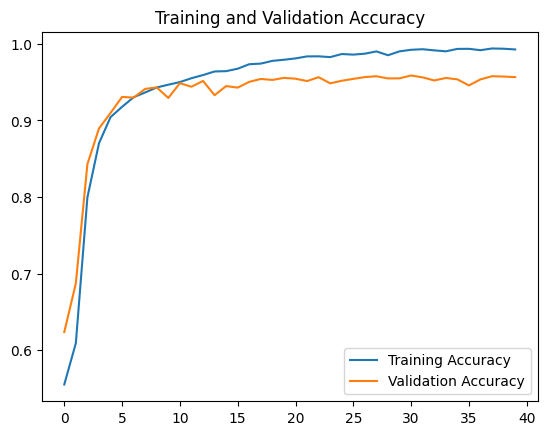

In [13]:
plt.plot(range(epochs), history["output_accuracy"], label="Training Accuracy")
plt.plot(range(epochs), history["val_output_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.show()

In [14]:
model.evaluate(test, return_dict=True)

40/40 [==============================] - 5s 130ms/step - loss: 0.3685 - output_loss: 0.2331 - aux1_loss: 0.2097 - aux2_loss: 0.2415 - output_accuracy: 0.9553 - output_precision: 0.9526 - output_recall: 0.9584 - aux1_accuracy: 0.9487 - aux1_precision: 0.9338 - aux1_recall: 0.9658 - aux2_accuracy: 0.9549 - aux2_precision: 0.9462 - aux2_recall: 0.9645


{'loss': 0.3684975206851959,
 'output_loss': 0.23313406109809875,
 'aux1_loss': 0.20973171293735504,
 'aux2_loss': 0.24148012697696686,
 'output_accuracy': 0.9553499817848206,
 'output_precision': 0.952589213848114,
 'output_recall': 0.9584000110626221,
 'aux1_accuracy': 0.9486500024795532,
 'aux1_precision': 0.9337716102600098,
 'aux1_recall': 0.9657999873161316,
 'aux2_accuracy': 0.9548500180244446,
 'aux2_precision': 0.9462376236915588,
 'aux2_recall': 0.9645000100135803}